## Jupyter notebook to demonstrate the basic calibration setup

This notebook runs the following tasks:
* Create a test Visibility dataset.
   * Not adding visibility sample noise. Just testing that things are working exactly as expected.
   * Using the GLEAM sky model and a common everybeam station beam model.
   * Add complex Gaussian noise corruptions to station gains and leakage.
   * Impose a wavelength^2-dependent rotate on each station Jones matrix 
* Predict model visibilities (using GLEAM and everybeam).
* Do polarised bandpass calibration.
* Fit for the wavelength^2-dependent rotation of each station.
* Redo polarised bandpass calibration.
* Use dask to handle processing of different frequency sub-bands.

This notebook requires:
* See imports.

In [1]:
# Demonstration of basic calibration

# pylint cannot seem to handle astropy units
# pylint: disable=no-member

import logging
import sys
import time as timer

# Imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from astropy import constants as const
from astropy import units
from astropy.coordinates import Angle, SkyCoord
from dask.distributed import Client, LocalCluster

# from ska_sdp_func_python.calibration.operations import apply_gaintable
from ska_sdp_datamodels.calibration.calibration_create import (
    create_gaintable_from_visibility,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration,
)
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.visibility.vis_create import create_visibility

from ska_sdp_instrumental_calibration.processing_tasks.calibration import (
    apply_gaintable,
    solve_bandpass,
)
from ska_sdp_instrumental_calibration.processing_tasks.lsm_tmp import (
    convert_model_to_skycomponents,
    generate_lsm,
)
from ska_sdp_instrumental_calibration.processing_tasks.predict import (
    predict_from_components,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
t0 = timer.perf_counter()

In [3]:
# Set up a local dask cluster and client

cluster = LocalCluster()
client = Client(cluster)

In [4]:
# Create a test Visibility dataset

# -------------------------------------------------------------------------- #
# Set up the array

# Read in an array configuration
low_config = create_named_configuration("LOWBD2")

# Down-select to a desired sub-array
#  - ECP-240228 modified AA2 clusters:
#      Southern Arm: S8 (x6), S9, S10 (x6), S13, S15, S16
#      Northern Arm: N8, N9, N10, N13, N15, N16
#      Eastern Arm: E8, E9, E10, E13.
#  - Most include only 4 of 6 stations, so just use the first 4:
AA2 = (
    np.concatenate(
        (
            345 + np.arange(6),  # S8-1:6
            351 + np.arange(4),  # S9-1:4
            429 + np.arange(6),  # S10-1:6
            447 + np.arange(4),  # S13-1:4
            459 + np.arange(4),  # S15-1:4
            465 + np.arange(4),  # S16-1:4
            375 + np.arange(4),  # N8-1:4
            381 + np.arange(4),  # N9-1:4
            471 + np.arange(4),  # N10-1:4
            489 + np.arange(4),  # N13-1:4
            501 + np.arange(4),  # N15-1:4
            507 + np.arange(4),  # N16-1:4
            315 + np.arange(4),  # E8-1:4
            321 + np.arange(4),  # E9-1:4
            387 + np.arange(4),  # E10-1:4
            405 + np.arange(4),  # E13-1:4
        )
    )
    - 1
)
mask = np.isin(low_config.id.data, AA2)
nstations = low_config.stations.shape[0]
low_config = low_config.sel(indexers={"id": np.arange(nstations)[mask]})

# Reset relevant station parameters
nstations = low_config.stations.shape[0]
low_config.stations.data = np.arange(nstations).astype("str")
low_config = low_config.assign_coords(id=np.arange(nstations))
# low_config.attrs["name"] = low_config.name+"-AA2"
low_config.attrs["name"] = "AA2-Low-ECP-240228"

print(f"Using {low_config.name} with {nstations} stations")

# -------------------------------------------------------------------------- #
# Set up the observation

# Set the phase centre in the ICRS coordinate frame
ra0 = Angle(0.0 * units.hourangle)
dec0 = Angle(-27.0 * units.deg)

# Set the parameters of sky model components
# chanwidth = 400e6 / 512  # station/CBF coarse channels = 781.25 kHz
chanwidth = 781.25e3  # Hz
nfrequency = 96
frequency = 781.25e3 * 128 + chanwidth * np.arange(nfrequency)
sample_time = 0.9  # seconds
solution_interval = sample_time  # would normally be minutes

# Set the phase centre hour angle range for the sim (in radians)
ha0 = 1 * np.pi / 12  # radians
ha = ha0 + np.arange(0, solution_interval, sample_time) / 3600 * np.pi / 12

# Create the Visibility dataset
vis = create_visibility(
    low_config,
    ha,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("linear"),
    phasecentre=SkyCoord(ra=ra0, dec=dec0),
    weight=1.0,
)

# Generate a true sky model and true visibilties for the whole band
gleamfile = "/data/EOS_1/mit183/gleamegc.dat"
fov = 10.0
flux_limit = 1
tsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)

eb_ms = "../data/OSKAR_MOCK.ms"
eb_coeffs = "/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs"

tsm_components = convert_model_to_skycomponents(tsm, vis.frequency.data)
predict_from_components(vis, tsm_components, eb_coeffs=eb_coeffs, eb_ms=eb_ms)

# Initially Jones matrices are 2x2 identity matrices
jones = create_gaintable_from_visibility(
    vis, jones_type="B", timeslice=solution_interval
)

np.random.seed(int(1e8))

# Add random complex antenna gain and leakage variations to the Jones matrices
g_sigma = 0.05
jones.gain.data += (
    np.random.normal(0, g_sigma, jones.gain.shape)
    + np.random.normal(0, g_sigma, jones.gain.shape) * 1j
)

# Multiply by ionospheric Faraday rotation
#  - Todo: rotate each component and each 5.4kHz channel separately
#  - Todo: use a phase screen. For now just have a gradient across the array
x = low_config.xyz.data[:, 0]
pp_rm = 1 + 4 * (x - np.min(x)) / (np.max(x) - np.min(x))
fr_mat = np.zeros((nstations, nfrequency, 2, 2))
lambda_sq = (const.c.value / frequency) ** 2
for stn in range(nstations):
    d_pa = pp_rm[stn] * lambda_sq
    fr_mat[stn] = np.stack(
        (np.cos(d_pa), -np.sin(d_pa), np.sin(d_pa), np.cos(d_pa)),
        axis=1,
    ).reshape(-1, 2, 2)
tmp = jones.gain.data.copy()
jones.gain.data = np.einsum("tsfpx,sfxq->tsfpq", tmp, fr_mat)

vis = apply_gaintable(vis=vis, gt=jones, inverse=False)

Using AA2-Low-ECP-240228 with 68 stations


2024-11-19 17:17:16,063 - processing_tasks.lsm_tmp - INFO - extracted 37 GLEAM components


extracted 37 GLEAM components
Initialising beams for Low
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could n

In [5]:
# Do pre-processing

# Get the LSM (single call for all channels / dask tasks)
lsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)

# Adapative RFI flagging is flagging too much
# (perhaps due to the rotations)

# Chunking of Visibility dataset in frequency
fchunk = nfrequency // 4

# Save a copy for final checks
vis_numpy = vis.copy(deep=True)

vis = vis.chunk({"frequency": fchunk})

2024-11-19 17:17:23,277 - processing_tasks.lsm_tmp - INFO - extracted 37 GLEAM components


extracted 37 GLEAM components


In [6]:
# Predict model visibilities

modelvis = vis.assign({"vis": xr.zeros_like(vis.vis)})
assert np.all(modelvis.vis.data == 0)

def _predict(vischunk, lsm):
    if len(vischunk.frequency) > 0:
        # Evaluate LSM for current band
        lsm_components = convert_model_to_skycomponents(
            lsm, vischunk.frequency.data, freq0=200e6
        )
        # Call predict
        predict_from_components(
            vischunk, lsm_components, eb_coeffs=eb_coeffs, eb_ms=eb_ms
        )
    return vischunk

modelvis = modelvis.map_blocks(_predict, args=[lsm]).persist()

# Make sure modelvis was updated
assert np.all(modelvis.vis.data != 0), "modelvis should have changed"

/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 13.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 107 MHz, using the nearest 

In [7]:
# Do the bandpass calibration

# Create a full-band bandpass calibration gain table
gaintable = create_gaintable_from_visibility(
    vis_numpy, jones_type="B", timeslice=solution_interval
).chunk({"frequency": fchunk})

refant = 0

# Add model and gaintable data to the observed vis dataset so a single
# map_blocks call can be made.
megaset = vis.assign(modelvis=modelvis.vis, gain=gaintable.gain)

def _solve(vischunk, solver, niter, refant):

    if len(vischunk.frequency) > 0:

        # Set multiple views into the combined dataset to keep the solver happy
        vis = vischunk.drop_vars(
            ["gain", "antenna", "receptor1", "receptor2", "modelvis"]
        )
        modelvis = vischunk.drop_vars(
            ["gain", "antenna", "receptor1", "receptor2", "vis"]
        ).rename({"modelvis": "vis"})
        solution_interval = np.max(vis.time.data) - np.min(vis.time.data)

        # Create a gaintable wrapper for the gain data
        gaintable = create_gaintable_from_visibility(
            vis,
            jones_type="B",
            timeslice=solution_interval,
        )
        gaintable.gain.data = vischunk.gain.data

        # Call the solver
        gaintable = solve_bandpass(
            vis=vis,
            modelvis=modelvis,
            gain_table=gaintable,
            solver=solver,
            niter=niter,
            refant=refant,
        )

    return vischunk

solver = "jones_substitution"
niter = 20
megaset = megaset.map_blocks(_solve, args=[solver, niter, refant]).persist()

# Copy solutions back across
gaintable.gain.data = megaset.gain.data

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
gaintable.gain.data *= np.exp(
    -1j
    * np.angle(
        gaintable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 28.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [8]:
def extract_rm(jones, lambda_sq, normalise=False):
    """Fit a rotation measure spectrum for each station Jones.

    For each station, the Jones matrix for each channel is used to
    operate on a unit vector. The result is expressed as a complex
    number, and the spectrum of complex numbers is the Fourier
    transformed with respect to wavelength squared. The peaks of this
    transformed spectrum is taken as the rotation measure for the
    stations.

    This function needs to be cleaned up, documented and added to the
    repository.
    """
    # reference against a single station
    ref = 0

    # fr_mat = np.zeros((nstations, nfrequency, 2, 2))
    nstations = jones.shape[1]
    assert jones.shape[2] == len(lambda_sq)

    oversample = 5
    rm_res = 1 / oversample / (np.max(lambda_sq) - np.min(lambda_sq))
    rm_max = 1 / (lambda_sq[-2] - lambda_sq[-1])
    # rm_vals = np.arange(0, rm_max, rm_res)
    rm_vals = np.arange(-rm_max, rm_max, rm_res)
    uvec = np.array([1, 0])
    rm_peeks = np.zeros(nstations)
    oneonN = 1 / len(frequency)
    for stn in range(nstations):
        # Reference against a single station
        ag_mat = np.einsum("fpx,fqx->fpq", jones[0, stn], jones[0, ref].conj())
        # Normalise?
        if normalise:
            ag_norm = np.linalg.norm(ag_mat, axis=(1, 2)) / np.sqrt(2)
            fr_mat = np.einsum("fpq,f->fpq", ag_mat, 1 / ag_norm)
        else:
            fr_mat = ag_mat
        # Rotate a unit vector per channel
        rvec = np.einsum("fpq,q->fp", fr_mat, uvec)
        # Express the results as a complex numbers
        f_spec = rvec[:, 0] + 1j * rvec[:, 1]
        # Take the RM transform of the complex numbers and find the peak
        rm_spec = oneonN * np.einsum(
            "rf,f->r", np.exp(np.outer(-1j * rm_vals, lambda_sq)), f_spec
        )

        # Only bother if peak is significant. TODO: What is significant?
        #  - real(rm_spec) is sharper, but can be affected by gain errors
        if np.max(np.abs(rm_spec)) > 0.5:
            rm_peeks[stn] = rm_vals[np.argmax(np.abs(rm_spec))]

        if stn == nstations - 5:
            plt.figure()
            ax = plt.subplot(111)
            ax.plot(rm_vals, np.abs(rm_spec), "b", label="abs")
            ax.plot(rm_vals, np.real(rm_spec), "c", label="re")
            ax.plot(rm_vals, np.imag(rm_spec), "m", label="im")
            ax.plot((pp_rm[stn] - pp_rm[0]) * np.ones(2), ax.get_ylim(), "r")
            ax.plot(rm_peeks[stn] * np.ones(2), ax.get_ylim(), "b--")
            ax.set_xlim((-7, 7))
            ax.grid()
            ax.legend()

    return rm_peeks

In [9]:
len(gaintable.antenna)

68

_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub


RM input: [ 0.      0.0009  0.0038  0.0046  0.1228  0.1218  0.1253  0.1198 -0.6654 -0.6699 -0.6706 -0.6679 -0.6714 -0.6638
 -0.5233 -0.5199 -0.519  -0.5224 -0.4915 -0.4859 -0.4884 -0.4913 -0.7532 -0.7572 -0.7582 -0.7601  0.1882  0.1949
  0.1916  0.1971  1.0515  1.0514  1.0523  1.057  -0.9647 -0.9682 -0.9646 -0.9692 -0.9647 -0.9612 -1.2832 -1.2865
 -1.2835 -1.28   -0.6278 -0.6229 -0.6281 -0.6263 -0.7096 -0.7122 -0.7076 -0.7098 -0.3996 -0.396  -0.4028 -0.397
 -1.0742 -1.0777 -1.0778 -1.0739 -2.1814 -2.1828 -2.1857 -2.1773 -2.9425 -2.943  -2.9408 -2.9386]

RM model: [ 0.      0.      0.      0.      0.0996  0.1327  0.1327  0.1327 -0.6637 -0.6637 -0.6969 -0.6637 -0.6637 -0.6637
 -0.531  -0.4978 -0.531  -0.531  -0.4978 -0.4978 -0.4978 -0.4978 -0.7633 -0.7633 -0.7633 -0.7633  0.1991  0.1991
  0.1991  0.1991  1.0288  1.062   1.062   1.062  -0.9624 -0.9624 -0.9624 -0.9624 -0.9624 -0.9624 -1.2943 -1.2943
 -1.2943 -1.2943 -0.6306 -0.6306 -0.6306 -0.6306 -0.7301 -0.7301 -0.7301 -0.6969 -0.3982 -

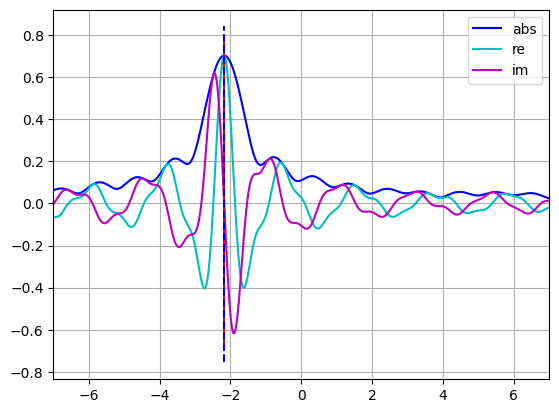

In [10]:
# Fit a rotation measure spectrum for each station Jones.

rm_update = extract_rm(
    gaintable.gain.as_numpy().data, lambda_sq, normalise=True
)

print(f"\nRM input: {pp_rm - pp_rm[0]}")
print(f"\nRM model: {rm_update - rm_update[0]}")
print(f"\nRM error: {(rm_update - rm_update[0]) - (pp_rm - pp_rm[0])}")
print(f"\nRM resolution: {1 / (np.max(lambda_sq) - np.min(lambda_sq)):.4f}\n")

In [11]:
# initialise gain table with rotation fits and retry calibration

gaintable = create_gaintable_from_visibility(
    vis_numpy, jones_type="B", timeslice=solution_interval
)
for stn in range(nstations):
    d_pa = (rm_update[stn] - rm_update[0]) * lambda_sq
    gaintable.gain.data[0, stn] = np.stack(
        (np.cos(d_pa), -np.sin(d_pa), np.sin(d_pa), np.cos(d_pa)),
        axis=1,
    ).reshape(-1, 2, 2)
gaintable = gaintable.chunk({"frequency": fchunk})

assert len(gaintable.time) == 1

refant = 0

# Add model and gaintable data to the observed vis dataset so a single
# map_blocks call can be made.
megaset = vis.assign(modelvis=modelvis.vis, gain=gaintable.gain)

solver = "normal_equations"
niter = 50
megaset = megaset.map_blocks(_solve, args=[solver, niter, refant]).compute()

# Copy solutions back across
#  - This may not be very efficient, but it will do for now
gaintable.gain.data = megaset.gain.data

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
finaldata = gaintable.gain.data * np.exp(
    -1j
    * np.angle(
        gaintable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

assert np.all(
    np.isclose(finaldata, inputdata)
), "Calibration should have converged."

print("done!")

/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 28.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


done!


In [12]:
# Shut down the scheduler and workers
client.close()
client.shutdown()

In [13]:
# On Intel(R) Xeon(R) W-2245 CPU @ 3.90GHz with 8 cores
# 64 channels in 16-chan chunks took 29.1 seconds
# 96 channels in  8-chan chunks took 62.7 seconds
# 96 channels in 16-chan chunks took 45.8 seconds
# 96 channels in 24-chan chunks took 39.0 seconds
# 96 channels in 48-chan chunks took 63.4 seconds

dt = timer.perf_counter() - t0
print(f"{nfrequency} channels in {fchunk}-chan chunks took {dt:.1f} seconds")

96 channels in 24-chan chunks took 40.0 seconds
